In [1]:
import numpy as np
from pymatgen.ext.matproj import MPRester
from pymatgen.core import Structure
from fireworks import LaunchPad
import os
from ph3pywf.workflows.core import wf_phono3py

####################
# FULL PHONO3PY WF #
####################
### Running conditions ##############################################
material_id = "mp-22862" # Material id to be searched on MP
supercell_size_fc3 = (2,2,2)
supercell_size_fc2 = (3,3,3)
cutoff_pair_distance = None
atom_disp = 0.03
# primitive_matrix = None

### Get working dir #################################################
working_dir = os.getcwd()

### Get materials structure #########################################
## If no local structure file, get from MP and save unitcell
## structure as "struct_unitcell.json"
if f"{material_id}_unitcell.json" in os.listdir(working_dir):
    print("Found local structure file")
    ## Read saved local structure file
    struct_unitcell = Structure.from_file(f"{material_id}_unitcell.json")

else:
    print("Getting structure from MaterialsProject")
    # api_key = ''
    with MPRester() as mpr:
        struct_unitcell = mpr.get_structure_by_material_id(material_id)

    ## Save a local structure file to avoid accessing MP every time
    with open(f"{material_id}_unitcell.json", "w") as fh:
        fh.write(struct_unitcell.to_json())

# print("Reading local file: POSCAR-unitcell")
# struct_unitcell = Structure.from_file("POSCAR-unitcell")


### Create the workflow #############################################
c = {"supercell_size_fc3": supercell_size_fc3, 
     "supercell_size_fc2": supercell_size_fc2,
     "cutoff_pair_distance": cutoff_pair_distance,
     "atom_disp": atom_disp,
     "is_nac": False,
     "USER_INCAR_SETTINGS": {"ENCUT": 520,
                             "EDIFF": 1e-5,
                             "EDIFFG": -1e-4,
                             "ALGO": "Normal",
                             "ISMEAR": 0,
                             "SIGMA": 0.01, 
                             "NSW": 500,
                            },
     "USER_INCAR_SETTINGS_STATIC": {"ENCUT": 520,
                                    "EDIFF": 0.0001,
                                    "ALGO": "Normal",
                                    "ISMEAR": 0,
                                    "SIGMA": 0.01, 
                                    "LREAL": ".FALSE.",
                                    "LWAVE": ".FALSE.", 
                                    "LCHARG": ".FALSE.", 
                                   },
#      "USER_POTCAR_SETTINGS": {"Mg": "Mg_sv"},
     "USER_POTCAR_FUNCTIONAL": "PBE_54",
     "USER_KPOINTS_SETTINGS": {"reciprocal_density": 128},
#      "primitive_matrix": primitive_matrix, 
     "metadata": {"tags": ["test",
                           "full phono3py wf",
                           "with post analysis", 
                           "modified static incar", 
                           "different incar for relax and static", 
                           "primitive unitcell",
                           "NAC off"], 
                 }
     }

print("Creating workflow...")
workflow = wf_phono3py(structure=struct_unitcell, 
                       c=c,
                      )
print("Created workflow")


### Create the launchpad and add our workflow #######################
print("Sending to LaunchPad...")
launchpad = LaunchPad.from_file("/home/jovyan/atomate/config/my_launchpad.yaml")
launchpad.add_wf(workflow)
print("Sent to LaunchPad")
print(">>Done<<")

successfully loaded custom FW_config.yaml with CONFIG_FILE_DIR at /home/jovyan/atomate/config


/opt/conda/lib/python3.8/site-packages/maggma/utils.py:20: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Getting structure from MaterialsProject
Creating workflow...
tag: "2021-08-08-13-56-51-305673"
{task_label: {$regex:"2021-08-08-13-56-51-305673"}}
Created workflow
Sending to LaunchPad...


/opt/conda/lib/python3.8/site-packages/pymatgen/io/vasp/sets.py:440: BadInputSetWarning: Overriding the POTCAR functional is generally not recommended  as it significantly affect the results of calculations and compatibility with other calculations done with the same input set. Note that some POTCAR symbols specified in the configuration file may not be available in the selected functional.
  warnings.warn(


2021-08-08 13:56:55,575 INFO Added a workflow. id_map: {-3: 8670, -2: 8671, -1: 8672}
Sent to LaunchPad
>>Done<<


In [2]:
##################
# CHECK PROGRESS #
##################

from fireworks import LaunchPad
launchpad = LaunchPad.from_file("/home/jovyan/atomate/config/my_launchpad.yaml")
tag = "2021-08-08-13-56-51-305673"

# Check progress 
RUNNING_ids = launchpad.get_fw_ids(
    {"state": "RUNNING", "name": {"$regex": tag}})
COMPLETED_ids = launchpad.get_fw_ids(
    {"state": "COMPLETED", "name": {"$regex": tag}})
FIZZLED_ids = launchpad.get_fw_ids(
    {"state": "FIZZLED", "name": {"$regex": tag}})
ALL_ids = launchpad.get_fw_ids({"name": {"$regex": tag}})

print(f"total: {len(ALL_ids)}\nRUNNING: {len(RUNNING_ids)}\nFIZZLED: {len(FIZZLED_ids)}\nCOMPLETED: {len(COMPLETED_ids)}")

# Rerun FIZZLED
for fw_id in FIZZLED_ids:
    print(f"INFO: rerunning FIZZLED fw: {fw_id}")
    launchpad.rerun_fw(fw_id)

# Rerun lost runs
LOST_ids = launchpad.detect_lostruns(expiration_secs=1*60*60)[1]
for fw_id in LOST_ids:
    print(f"INFO: rerunning lost run: {fw_id}")
    launchpad.rerun_fw(fw_id)

print("DONE")

total: 67
RUNNING: 0
FIZZLED: 0
COMPLETED: 67
DONE


In [ ]:
from fireworks import LaunchPad
launchpad = LaunchPad.from_file("/home/jovyan/atomate/config/my_launchpad.yaml")
launchpad.defuse_wf(8466)

In [ ]:
fw = launchpad.get_fw_by_id(2343)

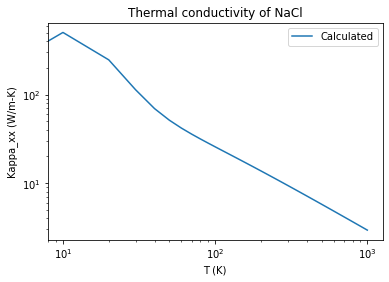

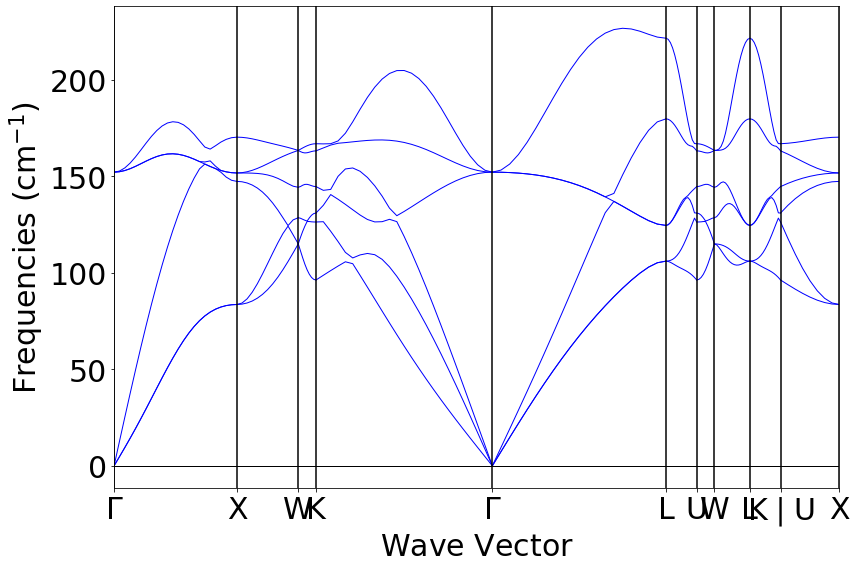

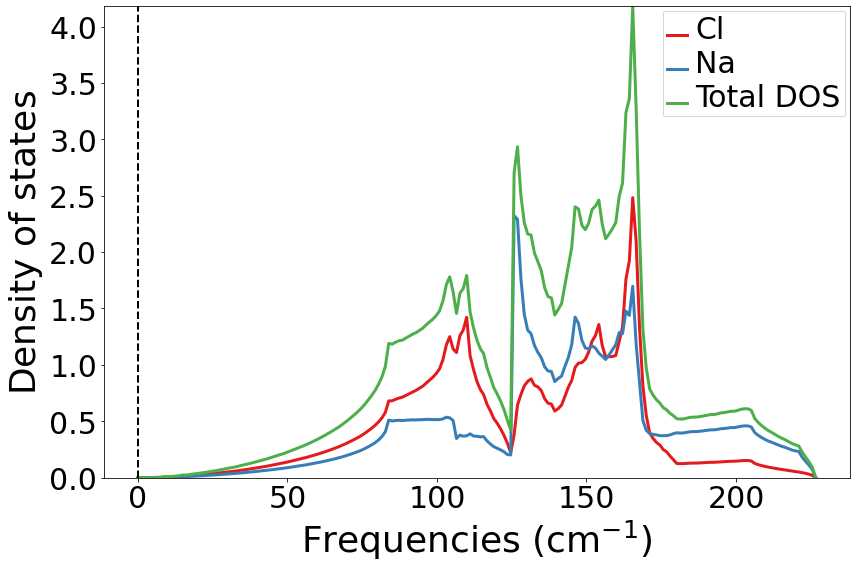

In [2]:
######################
# POST POST ANALYSIS #
######################
from atomate.vasp.database import VaspCalcDb
from pymatgen.core import Structure
import numpy as np
import matplotlib.pyplot as plt
from pymatgen.phonon.bandstructure import PhononBandStructureSymmLine
from pymatgen.phonon.dos import CompletePhononDos
from pymatgen.phonon.plotter import PhononBSPlotter, PhononDosPlotter
import csv

# create the atomate db from your db.json
PATH_TO_MY_DB_JSON = "/home/jovyan/atomate/config/db.json"
atomate_db = VaspCalcDb.from_db_file(PATH_TO_MY_DB_JSON)

# use the Gibbs collection
ph3py_coll = atomate_db.db["ph3py_tasks"]

# get our task 
task_label = "2021-08-08-13-56-51-305673"
ph3py_entry = ph3py_coll.find_one({"task_label": task_label})
formula_pretty = ph3py_entry["formula_pretty"]

# set up the pymatgen structure
struct = Structure.from_dict(ph3py_entry["structure"])

# # experiment value 1
# # ref: https://www.sciencedirect.com/science/article/pii/S1002007113001135
# T_exp_1 = []
# kappa_exp_xx_1 = []
# with open("ZrO2-thermal-conductivity-ref-1.csv", newline='') as f:
#     reader = csv.reader(f)
#     for row in reader:
#         T_exp_1.append(273 + float(row[0]))
#         kappa_exp_xx_1.append(float(row[1]))

# T_exp_1 = np.array(T_exp_1)
# kappa_exp_xx_1 = np.array(kappa_exp_xx_1)

# calculation result
T_calc = np.array(ph3py_entry["temperature"])
kappa_calc = np.array(ph3py_entry["kappa"])
kappa_calc_xx = kappa_calc[:,0]

# Plot our calculated kappa vs. experiment
# plt.scatter(T_exp_1, kappa_exp_xx_1, label="Reference 1")
plt.plot(T_calc, kappa_calc_xx, label="Calculated")
plt.title("Thermal conductivity of {}".format(formula_pretty))
plt.xscale("log")
plt.yscale("log")
plt.xlabel("T (K)")
plt.ylabel("Kappa_xx (W/m-K)")
plt.legend()

# save the figure
plt.savefig("{}-heat-conductivity-{}.png".format(formula_pretty, task_label))

# read band structure
bs = PhononBandStructureSymmLine.from_dict(ph3py_entry["band_structure"])

# plot band structure
plotter = PhononBSPlotter(bs)
plotter.show(units="cm-1")
plotter.save_plot("{}-phonon-dispersion-{}.png".format(formula_pretty, task_label),"png", units="cm-1")

# read dos
dos = CompletePhononDos.from_dict(ph3py_entry["dos"])

# plot dos
plotter = PhononDosPlotter()
plotter.add_dos("Total DOS", dos)
plotter.add_dos_dict(dos.get_element_dos())
plotter.show(units="cm-1")
plotter.save_plot("{}-phonon-DOS-{}.png".format(formula_pretty, task_label),"png",units="cm-1")


In [ ]:
##########################
# CHECK TIME OF EACH RUN #
##########################
from atomate.vasp.database import VaspCalcDb
mmdb = VaspCalcDb.from_db_file("/home/jovyan/atomate/config/db.json")

tag = "2021-07-17-02-32-45-355170"
docs_p = mmdb.collection.find(
    {
        "task_label": {"$regex": f"{tag}"},
    }
)

docs = []
for p in docs_p:
    docs.append(p)
# print(type(docs[0]))
for d in docs:
    print(d["task_label"])
    if "nsites" in d:
        print("nsites = {}".format(d["nsites"]))
    if "input" in d:
        print("EDIFF = {}".format(d["input"]["incar"]["EDIFF"]))
    if "run_stats" in d:
        if "standard" in d["run_stats"]:
            print("Maximum memory used (kb) = {}".format(d["run_stats"]["standard"]["Maximum memory used (kb)"]))
        print("Elapsed time (sec) = {}".format(d["run_stats"]["overall"]["Elapsed time (sec)"]))
    print("")